## Попытки полуколец в контексте ресурсных сетей

In [1]:
from resource_networks import *
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["axes.grid"] = True

plt.rcParams["font.size"] = 12

### Правильные структуры данных

#### Собственно, алгебра и матрицы:

In [2]:
#(transition, limitation) where (transition < limitation)
G = ResourceDiGraph()
G.add_outedges_of_node(0, {1: 3, 2: 4})
G.add_outedges_of_node(1, {0: 2, 2: 6})
sim = G.run_simulation({0: 30, 1: 50, 2: 1}, 40)
# G.plot()
pl = G.plot_with_states(sim)

In [3]:
f = lambda i: pl[i] #compose(identity, get_curried(pl))
interact(f, i=widgets.IntSlider(min=0,max=len(sim)-1,step=1,value=0)) 
None

interactive(children=(IntSlider(value=0, description='i', max=39), Output()), _dom_classes=('widget-interact',…

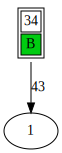

In [34]:
G = nx.DiGraph()
G.add_edge('dsd', 1, weight=2, label='43')

# G.graph['rankdir'] = 'LR'

# G.remove_edge(0, 1)
# first(G.edges(data=True))[2].get('weight')
# G.nodes['dsd']['penwidth'] = 4
# G.nodes['dsd']['label'] = """<
# <TABLE BORDER="0" CELLBORDER="1" CELLSPACING="0">
#   <TR><TD ROWSPAN="3" BGCOLOR="yellow">class</TD></TR>
#   <TR><TD PORT="here" BGCOLOR="lightblue">qualifier</TD></TR>
# </TABLE>>"""
G.nodes['dsd']['shape'] = 'plaintext'
G.nodes['dsd']['label'] = f"""<<table>
                          <tr><td>{'3' + '4'}</td></tr>
                          <tr><td bgcolor='#00CC11'>B</td></tr>
                       </table>>
"""
G.nodes['dsd']
SVG(nx.nx_pydot.to_pydot(G).create_svg())

In [ ]:
G_ = nx.nx_pydot.to_pydot(G)
G_.set('rankdir', 'LR')
SVG(G_.create_svg())

In [ ]:
B = np.array([[0, 2],
              [2, 0]])
# np.linalg.matrix_power(B, 2)
# np.apply_over_axes(lambda x: x**2, B, [])
B[0] = [2, 3]
B

In [ ]:
interact(f, Median_Size=widgets.IntSlider(min=1,max=21,step=2,value=1)) 